utilized from optuna for hyper parameter optimization technic.

and enhance performance of lstm model via best params

In [ ]:
# Import Required Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.ensemble import IsolationForest
import os
import optuna
import seaborn as sns
import json
import sys
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# Add the parent directory to the Python path
sys.path.append('../') 
from models.lstm_forecast_model import LSTMForecast
from models.timeseries_dataset_class import TimeSeriesDataset

# ✅ Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

In [ ]:

# SMAPE calculation
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

In [ ]:
# Evaluate model
def evaluate_model(model, dataloader, title, plot_name, writer=None, step=0):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            all_preds.append(pred)
            all_trues.append(y.numpy())
    predictions = np.concatenate(all_preds)
    truths = np.concatenate(all_trues)

    plt.figure(figsize=(10, 5))
    plt.plot(truths[:100], label="True")
    plt.plot(predictions[:100], label="Predicted")
    plt.legend()
    plt.title(title)
    plt.grid(True)
    os.makedirs("../../outputs/LSTM_Model", exist_ok=True)
    plot_path = f"../../outputs/LSTM_Model/{plot_name}"
    plt.savefig(plot_path)
    plt.show()
    print(f"✅ Plot saved to outputs/{plot_name}")

    mse = mean_squared_error(truths, predictions)
    mae = mean_absolute_error(truths, predictions)
    smape_val = smape(truths, predictions)
    print(f"📊 {title} Metrics:")
    print(f" - MSE   : {mse:.6f}")
    print(f" - MAE   : {mae:.6f}")
    print(f" - SMAPE : {smape_val:.2f}%")

    if writer:
        writer.add_scalar("Metrics/MSE", mse, step)
        writer.add_scalar("Metrics/MAE", mae, step)
        writer.add_scalar("Metrics/SMAPE", smape_val, step)

    return predictions, truths

In [ ]:
# Anomaly scoring based on residual thresholding
def anomaly_score(y_true, y_pred, threshold=3.0):

    # Ensure y_true and y_pred are 1D arrays with flattening or squeezing
    if y_true.ndim > 1:
        y_true = y_true.flatten()
    if y_pred.ndim > 1:
        y_pred = y_pred.flatten()

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape for anomaly detection.")

    residual = np.abs(y_true - y_pred)
    mean = np.mean(residual)
    std = np.std(residual)
    z_score = (residual - mean) / std
    anomalies = np.where(np.abs(z_score) > threshold)[0]


    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.scatter(anomalies, y_true[anomalies], color='red', label='Anomalies')
    plt.title("Anomaly Detection Result via z-score")
    plt.legend()
    plt.grid(True)
    plt.savefig("../../outputs/LSTM_Model/anomaly_detection_visual_z_score.png")
    plt.show()
    print("✅ Anomaly plot saved to anomaly_detection_visual_z_score.png")

    # Automatic anomaly description
    for idx in anomalies[:5]:
        true_val = float(np.ravel(y_true[idx])[0])
        pred_val = float(np.ravel(y_pred[idx])[0])
        z_val = float(np.ravel(z_score[idx])[0])
        print(f"⚠️ Anomaly at index {idx} → True: {true_val:.2f}, Predicted: {pred_val:.2f}, Z-score: {z_val:.2f}")
        
    return anomalies, z_score

In [ ]:
# Isolation Forest (optional advanced detector)
def isolation_forest_detection(residuals):
    iso = IsolationForest(contamination=0.01)
    preds = iso.fit_predict(residuals.reshape(-1, 1))
    anomalies = np.where(preds == -1)[0]
    return anomalies


In [ ]:
#  Isolation Forest Visualization
def visualize_isolation_forest_anomalies(y_true, y_pred, iso_anomalies):
    # Filter out-of-bounds indices
    iso_anomalies = [idx for idx in iso_anomalies if idx < len(y_true)]
    
    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label="True")
    plt.plot(y_pred, label="Predicted")

    plt.scatter(iso_anomalies, y_true[iso_anomalies], color="green", label="ISO Anomalies")

    plt.title("Isolation Forest - Anomaly Detection")
    plt.legend()
    plt.grid(True)

    iso_plot_path = "../../outputs/LSTM_Model/isolation_forest_anomaly_plot.png"
    plt.savefig(iso_plot_path)
    plt.show()
    print(f"✅ Isolation Forest anomaly plot saved to: {iso_plot_path}")

    for idx in iso_anomalies[:5]:
        true_val = float(np.ravel(y_true[idx])[0])
        pred_val = float(np.ravel(y_pred[idx])[0])
        residual_val = float(np.ravel(np.abs(y_true[idx] - y_pred[idx]))[0])
        print(f"🌪️ ISO Anomaly at index {idx} → True: {true_val:.2f}, Predicted: {pred_val:.2f}, Residual: {residual_val:.2f}")


In [24]:
# Train and evaluate with early stopping
def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, epochs=50, early_stop=5, writer=SummaryWriter(log_dir="../runs/LSTM_Model/train_and_eval")):
    best_val_loss = float('inf')
    patience = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).unsqueeze(1)
            optimizer.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        # writer.add_scalar("Loss/train", avg_train_loss, epoch)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device).unsqueeze(1)
                val_loss += loss_fn(model(x), y).item()
        avg_val_loss = val_loss / len(val_loader)
        # writer.add_scalar("Loss/val", avg_val_loss, epoch)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience = 0
        else:
            patience += 1
            if patience >= early_stop:
                break
    # writer.close()
    return best_val_loss

In [ ]:
# Optuna objective function
def objective(trial):
    window_size = trial.suggest_int("window_size", 24, 512)
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
    val_df = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")
    train_target = train_df["OT"].values
    val_target = val_df["OT"].values

    train_loader = DataLoader(TimeSeriesDataset(train_target, window_size), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TimeSeriesDataset(val_target, window_size), batch_size=batch_size, shuffle=False)

    model = LSTMForecast(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    return train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn)


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

In [ ]:

print("\n✅ Best Hyperparameters:")
print(study.best_trial.params)

In [ ]:

# Save best hyperparameters
os.makedirs("../models", exist_ok=True)
with open("../models/best_params_of_lstm_model.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=4)

In [ ]:

# Retrain model with best parameters
params = study.best_trial.params
window_size = params["window_size"]
batch_size = params["batch_size"]
train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
val_df = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")
test_df = pd.read_csv("../data/processed/etth1_test.csv", parse_dates=["date"], index_col="date")

# use the best parameters to create DataLoaders
train_loader = DataLoader(TimeSeriesDataset(train_df["OT"].values, window_size), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(val_df["OT"].values, window_size), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(test_df["OT"].values, window_size), batch_size=batch_size, shuffle=False)

model = LSTMForecast(hidden_size=params["hidden_size"], num_layers=params["num_layers"], dropout=params["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
loss_fn = nn.MSELoss()


In [25]:
train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn)
torch.save(model.state_dict(), "../models/checkpoints/lstm_model.pth")

[Epoch 1] Train Loss: 0.0004
[Epoch 2] Train Loss: 0.0004
[Epoch 2] Train Loss: 0.0004
[Epoch 3] Train Loss: 0.0004
[Epoch 3] Train Loss: 0.0004
[Epoch 4] Train Loss: 0.0004
[Epoch 4] Train Loss: 0.0004
[Epoch 5] Train Loss: 0.0004
[Epoch 5] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004


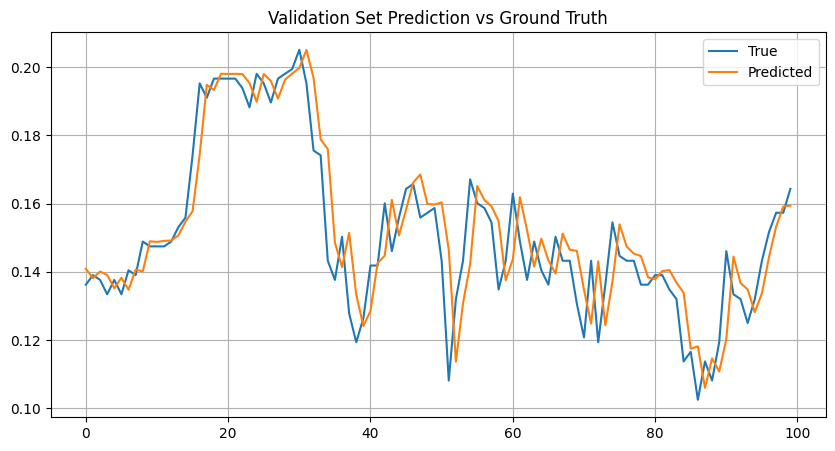

✅ Plot saved to outputs/lstm_model_val_predictions.png
📊 Validation Set Prediction vs Ground Truth Metrics:
 - MSE   : 0.000168
 - MAE   : 0.009136
 - SMAPE : 34.81%


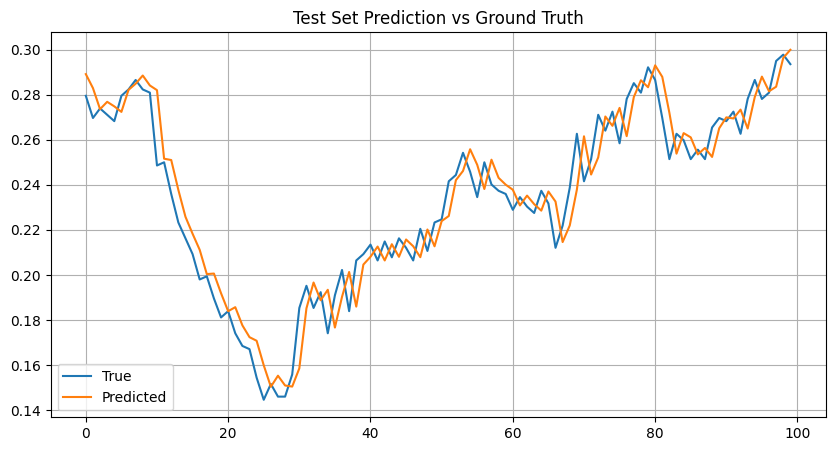

✅ Plot saved to outputs/lstm_model_test_predictions.png
📊 Test Set Prediction vs Ground Truth Metrics:
 - MSE   : 0.000174
 - MAE   : 0.008726
 - SMAPE : 19.14%


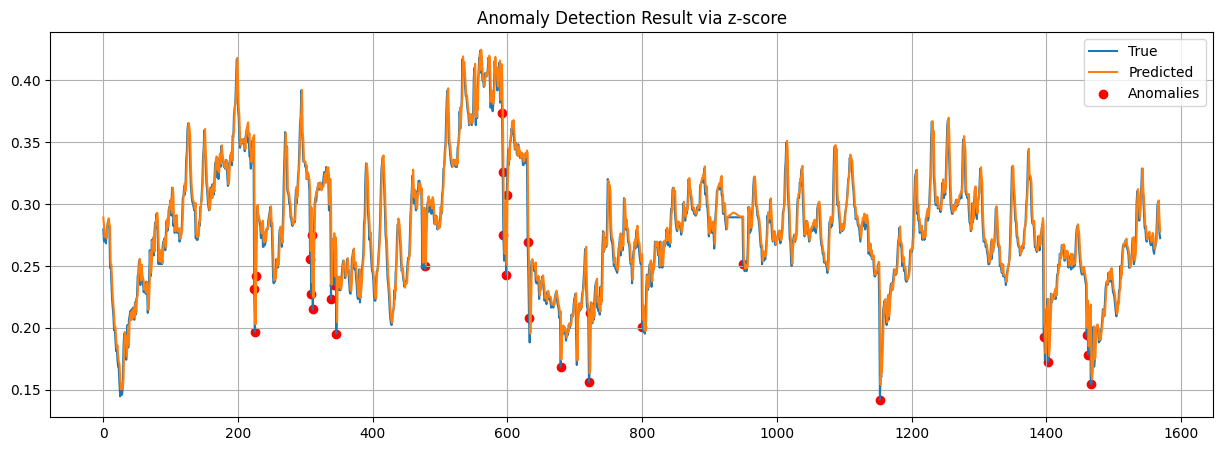

✅ Anomaly plot saved to anomaly_detection_visual_z_score.png
⚠️ Anomaly at index 224 → True: 0.23, Predicted: 0.36, Z-score: 11.65
⚠️ Anomaly at index 225 → True: 0.20, Predicted: 0.24, Z-score: 3.54
⚠️ Anomaly at index 226 → True: 0.24, Predicted: 0.20, Z-score: 3.03
⚠️ Anomaly at index 307 → True: 0.26, Predicted: 0.31, Z-score: 4.83
⚠️ Anomaly at index 309 → True: 0.23, Predicted: 0.30, Z-score: 6.17
🔎 Detected 29 anomalies in the test set


In [26]:
# Final evaluation
writer = SummaryWriter(log_dir="../runs/LSTM_Model/lstm_eval_final")
preds, trues = evaluate_model(model, val_loader, "Validation Set Prediction vs Ground Truth", "lstm_model_val_predictions.png", writer, step=0)
preds_test, trues_test = evaluate_model(model, test_loader, "Test Set Prediction vs Ground Truth", "lstm_model_test_predictions.png", writer, step=1)

# Anomaly detection with z-score
z_score_anomalies, z_score = anomaly_score(trues_test, preds_test)
print(f"🔎 Detected {len(z_score_anomalies)} anomalies in the test set")

# Save anomalies and z-scores
np.save("../../outputs/LSTM_Model/z_score_anomaly_indices.npy", z_score_anomalies)
np.save("../../outputs/LSTM_Model/z_scores.npy", z_score)

🌪️ Detected 15 anomalies using Isolation Forest


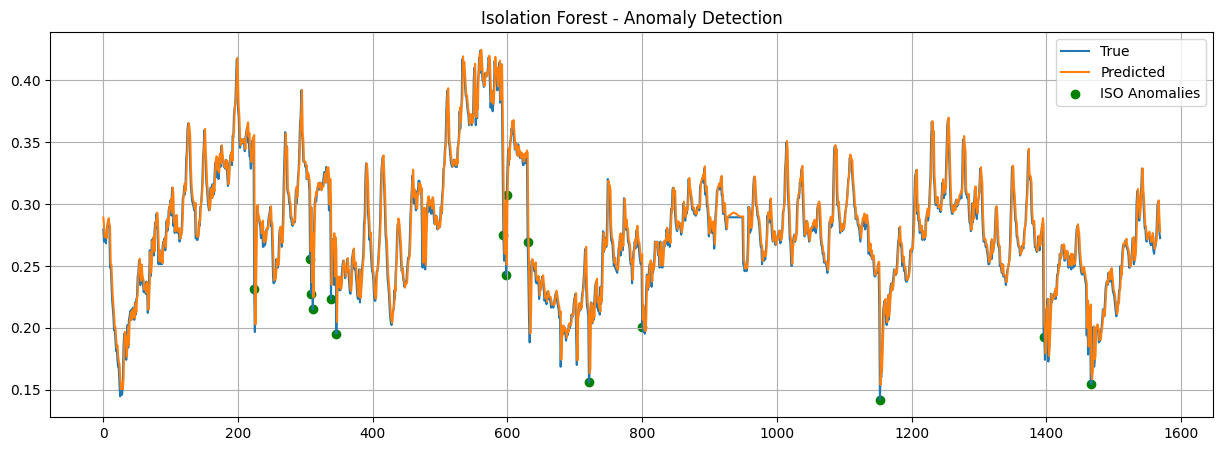

✅ Isolation Forest anomaly plot saved to: ../../outputs/LSTM_Model/isolation_forest_anomaly_plot.png
🌪️ ISO Anomaly at index 224 → True: 0.23, Predicted: 0.36, Residual: 0.12
🌪️ ISO Anomaly at index 307 → True: 0.26, Predicted: 0.31, Residual: 0.06
🌪️ ISO Anomaly at index 309 → True: 0.23, Predicted: 0.30, Residual: 0.07
🌪️ ISO Anomaly at index 311 → True: 0.21, Predicted: 0.28, Residual: 0.06
🌪️ ISO Anomaly at index 338 → True: 0.22, Predicted: 0.30, Residual: 0.08


In [27]:
# Isolation Forest anomaly detection

# convert preds_test and trues_test to 1D array with squeeze or flatten

if preds_test.ndim > 1:
    preds_test = preds_test.squeeze()
if trues_test.ndim > 1:
    trues_test = trues_test.squeeze()

residuals = np.abs(trues_test - preds_test)

iso_anomalies = isolation_forest_detection(residuals)

print(f"🌪️ Detected {len(iso_anomalies)} anomalies using Isolation Forest")

visualize_isolation_forest_anomalies(trues_test, preds_test, iso_anomalies)

# Close the TensorBoard writer

writer.close()

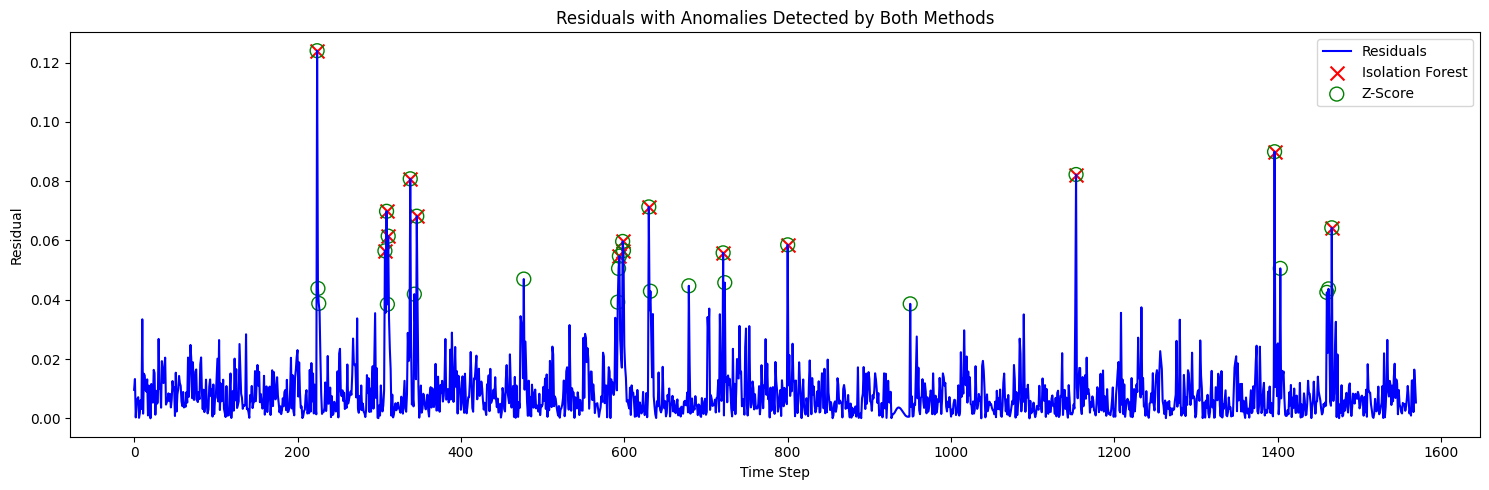

In [28]:
# Compare both anomaly detection methods (e.g., IForest & Z-Score) in one plot

# Ensure residuals is a NumPy array
residuals_np = residuals if isinstance(residuals, np.ndarray) else residuals.values
iso_anomalies_np = iso_anomalies if isinstance(iso_anomalies, np.ndarray) else iso_anomalies.values
zscore_anomalies_np = z_score_anomalies if isinstance(z_score_anomalies, np.ndarray) else z_score_anomalies.values

# Use np.arange for time steps
time_steps = np.arange(len(residuals_np))

plt.figure(figsize=(15, 5))
plt.plot(time_steps, residuals_np, label='Residuals', color='blue')

# Plot isolation forest anomalies
plt.scatter(time_steps[iso_anomalies_np], residuals_np[iso_anomalies_np],
            color='red', marker='x', label='Isolation Forest',s=100)

# Plot z-score anomalies
plt.scatter(time_steps[zscore_anomalies_np], residuals_np[zscore_anomalies_np],
            color='green', marker='o', label='Z-Score', facecolors='none',s=100)

plt.title("Residuals with Anomalies Detected by Both Methods")
plt.xlabel("Time Step")
plt.ylabel("Residual")
plt.legend()
plt.tight_layout()
plt.savefig("../../outputs/LSTM_Model/compare_anomaly_detection_methods.png")
plt.show()



📊 Final Evaluation Metrics:


C:\Users\aastm-sw\AppData\Local\Temp\ipykernel_7524\1885338416.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_df['Metric'], rotation=45, ha='right')


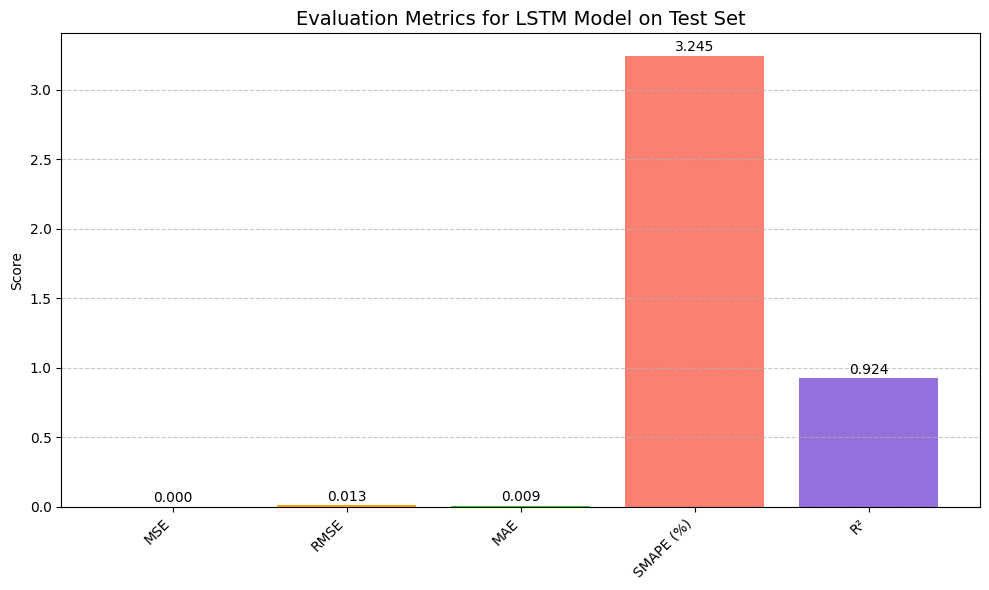

In [29]:
# calculate prediction accuracy and anomaly detection metrics
print("\n📊 Final Evaluation Metrics:")

preds_test = preds_test.flatten()
trues_test = trues_test.flatten()

mse= mean_squared_error(trues_test, preds_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(trues_test, preds_test)
r2 = r2_score(trues_test, preds_test)

smape_val = smape(trues_test, preds_test)

metrics_data = { 
    'Metric': ['MSE', 'RMSE', 'MAE', 'SMAPE (%)', 'R²'],
    'Score': [mse, rmse, mae, smape_val, r2]
}

# 'Anomalies_Z_Score','Anomalies_ISO_Forest' 
# len(z_score_anomalies), len(iso_anomalies)

metrics_df = pd.DataFrame(metrics_data)

colors = ['skyblue', 'orange', 'limegreen', 'salmon', 'mediumpurple', 'lightcoral', 'gold']

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xticklabels(metrics_df['Metric'], rotation=45, ha='right')
bars = ax.bar(metrics_df['Metric'], metrics_df['Score'], color=colors)

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_title('Evaluation Metrics for LSTM Model on Test Set', fontsize=14)
ax.set_ylabel('Score')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 ROC AUC Score: 1.0000


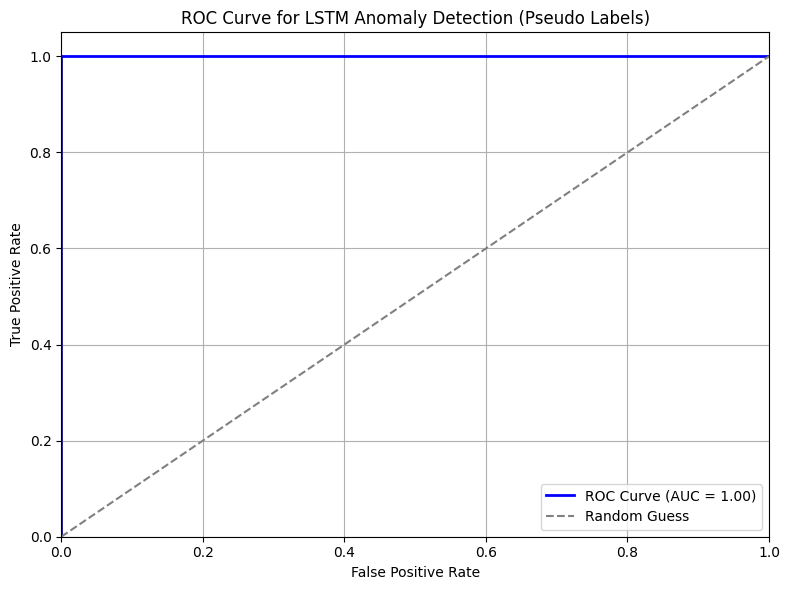

In [30]:
y_true = np.zeros_like(residuals)
y_true[iso_anomalies] = 1  # 1 = anomaly, 0 = normal

#Use residuals as anomaly scores
y_scores = residuals

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(f" ROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LSTM Anomaly Detection (Pseudo Labels)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:

# make above operations for precision, recall and f1-score

# print("trues_test :", trues_test)

# print("preds_test :", preds_test)

# pred_residuals = np.abs(trues_test - preds_test)

# # Step 2: Create pseudo-ground-truth by thresholding true values
# # Here we assume large changes in actual values mean real anomalies
# true_residuals = np.abs(trues_test - np.mean(trues_test))
# anomaly_threshold = np.percentile(true_residuals, 95)  # top 5% residuals = anomalies
# true_binary_labels = (true_residuals > anomaly_threshold).astype(int)

# # Step 3: ROC curve
# fpr, tpr, thresholds = roc_curve(true_binary_labels, pred_residuals)
# auc_score = roc_auc_score(true_binary_labels, pred_residuals)

# # Step 4: Plot
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color='blue')
# plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Unsupervised Anomaly Detection (ETTh1 - OT)')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f"AUC Score: {auc_score:.4f}")



1. Inject synthetic anomalies into the OT column of ETTh1
   - Why? Since the original dataset has no labels, you artificially inject anomalies (e.g., spikes, drops, out-of-distribution values) to create known positions of anomalies, i.e., y_true.

2. Train your LSTM model on the original (clean) ETTh1
   - This gives the model a sense of what "normal" time-series behavior looks like.

3. Evaluate on the anomaly-injected version of the dataset
   - Feed the injected dataset through the LSTM model to get predicted values.

   - Calculate residuals (absolute difference between prediction and actual).

   - These residuals serve as anomaly scores → y_scores.

4. Use the injected anomaly positions as ground-truth (y_true)
   - The y_true is a binary array where injected anomaly indices are 1, all others 0.

   - Use y_scores and y_true for:

        - roc_auc_score

        - precision_recall_curve

        - f1_score, precision, recall

        - confusion_matrix




“How do I know that the injected data contains anomalies?”

You create and control the anomalies yourself — so you define where they are and what kind they are. These synthetic changes become your ground-truth anomaly labels (y_true). The types of anomalies can include:

    -  Point anomalies: Inject random spikes or dips (e.g., multiply a value by 2x or set to 0)

    -  Contextual anomalies: Break seasonality by shifting values only in specific time windows

    -  Collective anomalies: Introduce a sequence of values that deviate from normal patterns



In [32]:
def inject_anomalies(data, anomaly_fraction=0.02, seed=42):
    np.random.seed(seed)
    n = len(data)
    total_anomaly_count = int(anomaly_fraction * n)

    # keep original data
    original_data = data.copy()
    anomaly_labels = np.zeros(n)
    anomaly_types = np.array(["normal"] * n, dtype=object)

    # Basic stats
    data_mean = np.mean(data)
    data_std = np.std(data)

    # Allocate anomalies by expected impact size
    # point: 1 point per injection
    # contextual: 1 point per injection
    # collective: 5 points per injection


    # Anomaly types: KEYNOTE
    # -  Point anomalies: Inject random spikes or dips (e.g., multiply a value by 2x or set to 0)
    # -  Contextual anomalies: Break seasonality by shifting values only in specific time windows
    # -  Collective anomalies: Introduce a sequence of values that deviate from normal patterns

    point_budget = int(0.3 * total_anomaly_count)
    contextual_budget = int(0.3 * total_anomaly_count)
    collective_budget = total_anomaly_count - point_budget - contextual_budget

    # --- Point anomalies ---
    indices_point = np.random.choice(n, size=point_budget, replace=False)
    data[indices_point] += np.random.normal(
        loc=1.5 * data_mean, scale=0.3 * data_std, size=point_budget
    )
    anomaly_labels[indices_point] = 1
    anomaly_types[indices_point] = "point"

    # --- Contextual anomalies ---
    window_size = 12
    indices_contextual = np.random.choice(
        range(window_size, n - window_size), size=contextual_budget, replace=False
    )
    for idx in indices_contextual:
        local_mean = np.mean(data[idx - window_size : idx])
        data[idx] = local_mean + np.random.normal(
            loc=0.8 * data_std, scale=0.2 * data_std
        )
        anomaly_labels[idx] = 1
        anomaly_types[idx] = "contextual"

    # --- Collective anomalies ---
    collective_seq_length = 5
    collective_count = collective_budget // collective_seq_length
    indices_collective = np.random.choice(
        range(n - collective_seq_length), size=collective_count, replace=False
    )
    for idx in indices_collective:
        anomaly_sequence = np.random.normal(
            loc=data_mean + 1.0 * data_std, scale=0.3 * data_std, size=5
        )
        data[idx : idx + 5] = anomaly_sequence
        anomaly_labels[idx : idx + 5] = 1
        anomaly_types[idx : idx + 5] = "collective"

    return original_data, data, anomaly_labels, anomaly_types


In [33]:
def plot_anomalies_with_colors(original_data, injected_data, types):
    plt.figure(figsize=(15, 5))

    # Plot original data line
    plt.plot(
        original_data,
        label="Original Test Data",
        color="green",
        alpha=0.9,
        linewidth=1.2,
        zorder=1,
    )

    # Highlight only anomaly points with scatter plots in different colors
    anomaly_colors = {"point": "red", "contextual": "orange", "collective": "pink"}

    for anomaly_type, color in anomaly_colors.items():
        indices = np.where(types == anomaly_type)[0]
        if len(indices) > 0:
            plt.scatter(
                indices,
                injected_data[indices],
                label=f"{anomaly_type.capitalize()} Anomaly",
                color=color,
                s=50,
                linewidths=0.7,
                edgecolors="black",
                zorder=3,
            )

    plt.title("ETTh1 - Test Data with Injected Anomalies Highlighted")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

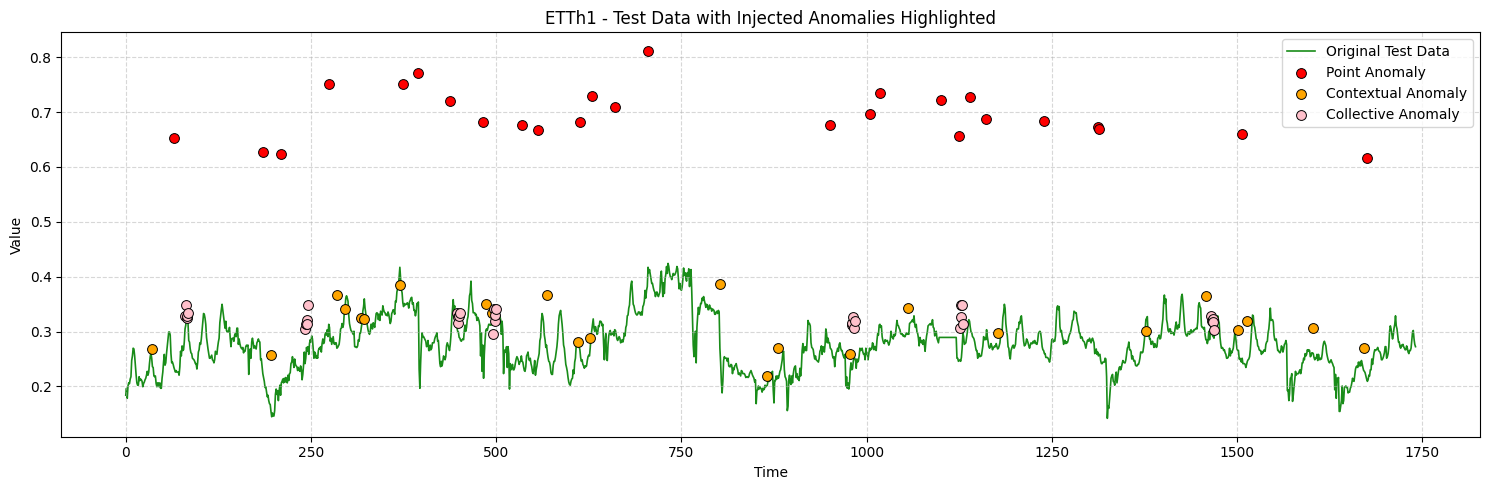

In [34]:
test_df = pd.read_csv("../data/processed/etth1_test.csv", parse_dates=["date"], index_col="date")

raw_test = test_df["OT"].values.copy()

#inject anomalies into the test set
original_test_data, test_data_with_anomalies, anomaly_labels, anomaly_types = inject_anomalies(raw_test.copy(), anomaly_fraction=0.05)

plot_anomalies_with_colors(original_test_data, test_data_with_anomalies, anomaly_types)

# Save the modified test data with anomalies
np.save("../data/processed/etth1_test_with_anomalies.npy", test_data_with_anomalies)

# Save the anomaly labels
np.save("../data/processed/etth1_anomaly_labels.npy", anomaly_labels)

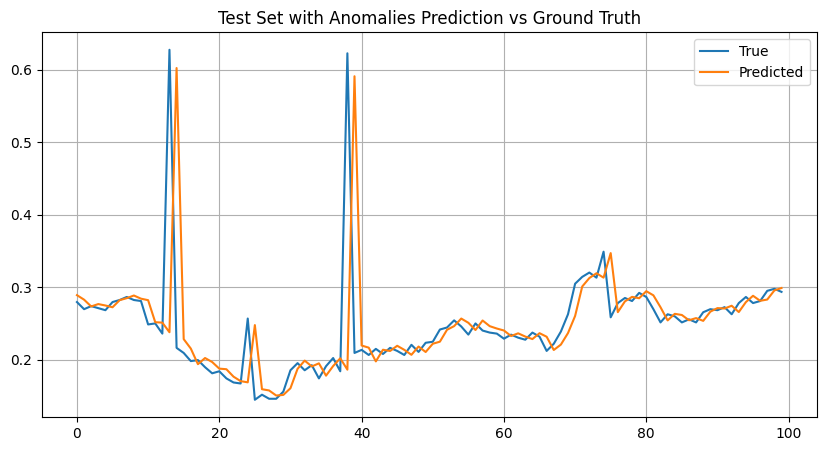

✅ Plot saved to outputs/lstm_model_test_with_anomalies_predictions.png
📊 Test Set with Anomalies Prediction vs Ground Truth Metrics:
 - MSE   : 0.005515
 - MAE   : 0.022890
 - SMAPE : 21.29%


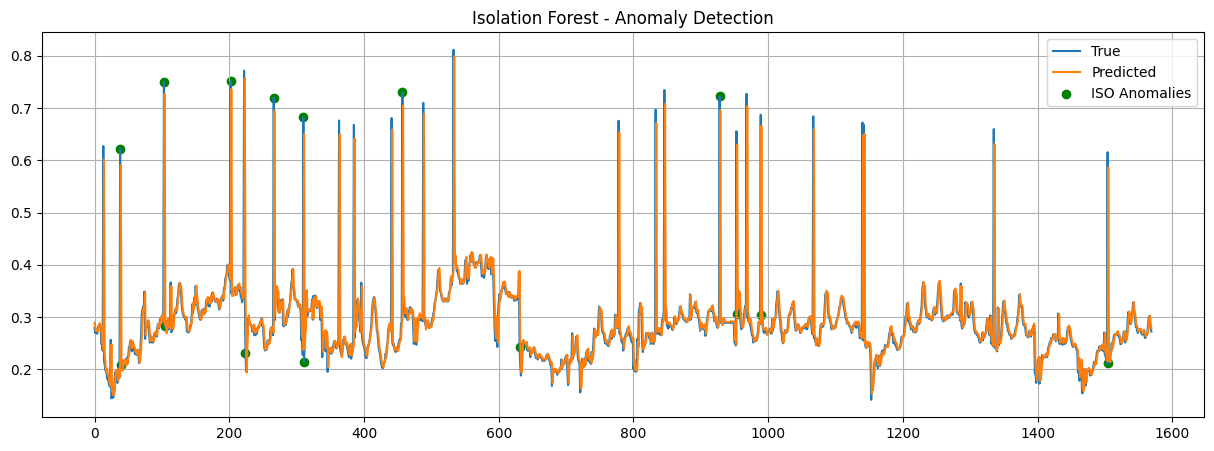

✅ Isolation Forest anomaly plot saved to: ../../outputs/LSTM_Model/isolation_forest_anomaly_plot.png
🌪️ ISO Anomaly at index 38 → True: 0.62, Predicted: 0.19, Residual: 0.44
🌪️ ISO Anomaly at index 39 → True: 0.21, Predicted: 0.59, Residual: 0.38
🌪️ ISO Anomaly at index 103 → True: 0.75, Predicted: 0.31, Residual: 0.44
🌪️ ISO Anomaly at index 104 → True: 0.28, Predicted: 0.73, Residual: 0.44
🌪️ ISO Anomaly at index 202 → True: 0.75, Predicted: 0.37, Residual: 0.38
ROC AUC Score on Modified Test Set: 0.8628


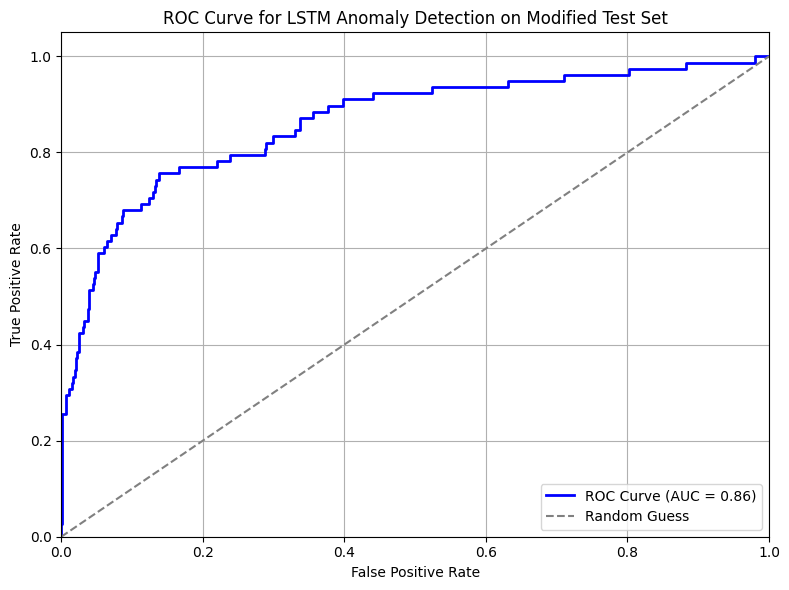

In [35]:

# Create a new DataLoader for the modified test set
test_loader_with_anomalies = DataLoader(TimeSeriesDataset(test_data_with_anomalies, window_size), batch_size=batch_size, shuffle=False)

# Evaluate the model on the modified test set with anomalies
preds_with_anomalies, trues_with_anomalies = evaluate_model(model, test_loader_with_anomalies, "Test Set with Anomalies Prediction vs Ground Truth", "lstm_model_test_with_anomalies_predictions.png", writer, step=2)


# isolation forest anomaly detection on the modified test set
# convert preds_with_anomalies and trues_with_anomalies to 1D array
if preds_with_anomalies.ndim > 1:
    preds_with_anomalies = preds_with_anomalies.squeeze()
if trues_with_anomalies.ndim > 1:
    trues_with_anomalies = trues_with_anomalies.squeeze()
# calculate residuals
residuals_with_anomalies = np.abs(trues_with_anomalies - preds_with_anomalies)
# Isolation Forest anomaly detection on the modified test set
iso_anomalies_with_anomalies = isolation_forest_detection(residuals_with_anomalies)
# Visualize Isolation Forest anomalies on the modified test set
visualize_isolation_forest_anomalies(trues_with_anomalies, preds_with_anomalies, iso_anomalies_with_anomalies)


# get true targets (shifted by window size)
trues_targets = test_data_with_anomalies[window_size:]
true_labels = anomaly_labels[window_size:]

# residuals

residuals=np.abs(preds_with_anomalies - trues_targets)

# ROC AUC

fpr, tpr, thresholds = roc_curve(true_labels, residuals)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC Score on Modified Test Set: {roc_auc:.4f}")

# Plot ROC Curve for modified test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LSTM Anomaly Detection on Modified Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("../../outputs/LSTM_Model/roc_curve_modified_test_set.png")
plt.show()